# The Bootstrap and the Jackknife

We present an example showing how to estimate the standard error of the correlation between two random vectors using the non-parametric bootstrap and the jackknife.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

from mltools.resampling import Bootstrap, Jackknife
from mltools import datasets

## The Data

Our data consist of average LSAT scores and average grade point averages (GPA) of the 1973 entering classes of $n=15$ American law schools.

In [2]:
data = datasets.load_lsat_gpa()
print(data)

    LSAT   GPA
0    576  3.39
1    635  3.30
2    558  2.81
3    578  3.03
4    666  3.44
5    580  3.07
6    555  3.00
7    661  3.43
8    651  3.36
9    605  3.13
10   653  3.12
11   575  2.74
12   545  2.76
13   572  2.88
14   594  2.95


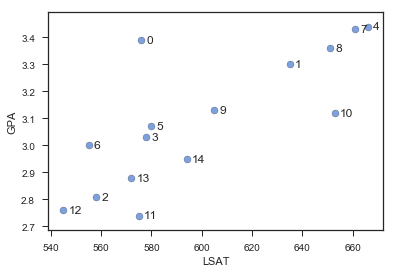

In [3]:
plt.figure()
plt.scatter(data.LSAT, data.GPA, c="b", edgecolor="k", alpha=0.7)
for i in range(len(data)):
    plt.text(data.LSAT[i] + 2, data.GPA[i], str(i),
             horizontalalignment="left", verticalalignment="center")
plt.xlabel("LSAT")
plt.ylabel("GPA")
plt.show()
plt.close()

Suppose we wish to estimate the correlation between average LSAT scores and average GPA using the Pearson correlation coefficient of our sample.

In [4]:
def correlation(x, y):
    """Pearson correlation coefficient between x and y."""
    # Coerce into NumPy arrays
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Center x and y by subtracting off their sample means
    x = x - x.mean()
    y = y - y.mean()
    
    # Return the Pearson correlation coefficient
    return x.dot(y) / np.sqrt(x.dot(x) * y.dot(y))

### Observed Correlation Estimate

In [5]:
corr = correlation(data.LSAT, data.GPA)
print(f"Observed correlation: {corr:.3f}")

Observed correlation: 0.776


We wish to quantify the accuracy of this estimate of the correlation.
One way of doing this is to report the *standard error* of our estimator.
Since the distribution of the estimator is unknown, we estimate this standard error using the bootstrap and the jackknife.

## Using the Bootstrap

MLTools provides a general-purpose bootstrap class `Bootstrap` in its `resampling` module to perform sampling distribution estimation.

In [6]:
%%time
boot = Bootstrap(data.LSAT, data.GPA, stat=correlation, n_boot=10000, random_state=0)

CPU times: user 461 ms, sys: 8.23 ms, total: 469 ms
Wall time: 486 ms


### Visualizing the Bootstrap Sampling Distribution

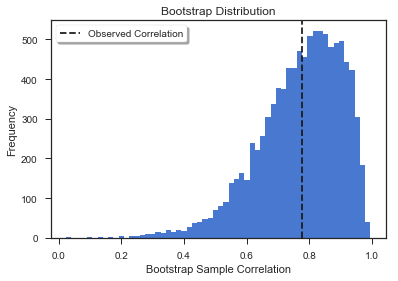

In [7]:
plt.figure()
plt.hist(boot.dist, bins="auto")
plt.axvline(boot.observed, ls="--", c="k", label="Observed Correlation")
plt.xlabel("Bootstrap Sample Correlation")
plt.ylabel("Frequency")
plt.legend(loc="best", frameon=True, shadow=True)
plt.title("Bootstrap Distribution")
plt.show()
plt.close()

### Estimating the Standard Error

In [8]:
se_boot = boot.se()
print(f"Bootstrap standard error: {se_boot:.3f}")

Bootstrap standard error: 0.134


## Using the Jackknife

MLTools provides a general-purpose jackknife class `Jackknife` in its `resampling` module to perform sampling distribution estimation.

In [9]:
%%time
jack = Jackknife(data.LSAT, data.GPA, stat=correlation)

CPU times: user 2.44 ms, sys: 1.26 ms, total: 3.7 ms
Wall time: 3.04 ms


### Visualizing the Jackknife Sampling Distribution

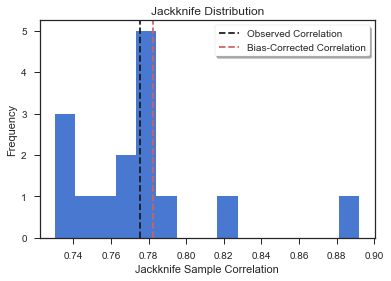

In [10]:
plt.figure()
plt.hist(jack.dist, bins=jack.n_sample)
plt.axvline(jack.observed, ls="--", c="k", label="Observed Correlation")
plt.axvline(jack.estimate(), ls="--", c="r", label="Bias-Corrected Correlation")
plt.xlabel("Jackknife Sample Correlation")
plt.ylabel("Frequency")
plt.legend(loc="best", frameon=True, shadow=True)
plt.title("Jackknife Distribution")
plt.show()
plt.close()

### Jackknife Estimates

In [11]:
print(f"Jackknife bias estimate: {jack.bias():.3f}")
print(f"Jackknife bias-corrected estimate: {jack.estimate():.3f}")
print(f"Jackknife standard error: {jack.se():.3f}")

Jackknife bias estimate: -0.007
Jackknife bias-corrected estimate: 0.782
Jackknife standard error: 0.143


# Theory

## Estimating Correlation

If $X$ and $Y$ are real-valued square-integrable random variables, then their *correlation* is defined to be
$$
\rho(X, Y)
= \frac{\mathrm{Cov}(X, Y)}{\mathrm{SD}(X) \mathrm{SD}(Y)}
= \frac{E[(X - E[X]) (Y - E[Y])]}{\sqrt{E\left[\left(X-E[X]\right)^2\right] E\left[\left(Y-E[Y]\right)^2\right]}}.
$$
This is a measure of the linear association between $X$ and $Y$.
By the Cauchy-Schwartz inequality, $\rho \in [-1, 1]$.
If $\rho(X, Y) = 1$, then $X$ and $Y$ have a perfect positive linear association; if $\rho(X, Y) = -1$, then $X$ and $Y$ have a perfect negative linear association; if $\rho(X, Y) = 0$, then $X$ and $Y$ have no linear association (this is the case, e.g., if $X$ and $Y$ are independent).

Let $\mu$ be the joint distribution of $(X, Y)$, which is a probability measure $\mu$ on $\mathcal{B}(\mathbb{R}^2)$, the Borel $\sigma$-algebra of $\mathbb{R}^2$, and let
$$
\mu_1(A) = \mu(A \times \mathbb{R}),
\qquad
\mu_2(B) = \mu(\mathbb{R} \times B)
$$
denote the marginal distributions of $X$ and $Y$, respectively.
Then
$$
\rho(X, Y)
= \frac{\int_{\mathbb{R}^2} \left(x - \int_{\mathbb{R}} u \, d\mu_1(u)\right)
\left(y - \int_{\mathbb{R}} v \, d\mu_2(v)\right) \, d\mu(x, y)}
{\sqrt{\left(\int_{\mathbb{R}} \left(x - \int_{\mathbb{R}} u \, d\mu_1(u)\right)^2 \, d\mu_1(x)\right)
\left(\int_{\mathbb{R}} \left(y - \int_{\mathbb{R}} v \, d\mu_2(v)\right)^2 \, d\mu_2(u)\right)}},
$$
which shows that $\rho(X, Y)$ is really just a functional of $\mu$.
Hence we can write $\rho(\mu)$ instead of $\rho(X, Y)$.

Suppose we have an independent and identically distributed (i.i.d.) sample $(X_1, Y_2), \ldots, (X_n, Y_n)$ of size $n$ drawn from some probability measure $\mu$ on $\mathcal{B}(\mathbb{R}^2)$, and let $\mathbf{X} = (X_1, \ldots, X_n)$ and $\mathbf{Y} = (Y_1, \ldots, Y_n)$.
If $\mu$ is unknown and only a realization of $\mathbf{X}$ and $\mathbf{Y}$ is observed, then is natural to estimate $\rho(\mu)$ by the *Pearson correlation coefficient* of $\mathbf{X}$ and $\mathbf{Y}$:
$$
\widehat{\rho}_n(\mathbf{X}, \mathbf{Y})
= \frac{\sum_{i=1}^n (X_i - \bar{\mathbf{X}}) (Y_i - \bar{\mathbf{Y}})}
{\sqrt{\left(\sum_{i=1}^n \left(X_i - \bar{\mathbf{X}}\right)^2\right)
\left(\sum_{i=1}^n \left(Y_i - \bar{\mathbf{Y}}\right)^2\right)}},
$$
where
$$
\bar{\mathbf{X}} = \frac{1}{n} \sum_{i=1}^n X_i, \qquad
\bar{\mathbf{Y}} = \frac{1}{n} \sum_{i=1}^n Y_i
$$
are the sample means of $\mathbf{X}$ and $\mathbf{Y}$.
Note that the estimator $\widehat{\rho}_n(\mathbf{X}, \mathbf{Y})$ is a random variable, while the true correlation $\rho(\mu)$ is a constant.

## The Jackknife

### General Theory

In general, suppose we have an i.i.d. sample $\mathbf{X} = (X_1, \ldots, X_n)$ ($n \geq 2$) drawn from an unknown probability measure $\mu$ on a Borel space $(\mathcal{X}, \mathcal{B})$ (so $\mathbf{X}$ is a random quantity taking values in $\mathcal{X}^n$).
Suppose further that $(\mathcal{Y}, \mathcal{C})$ is another Borel space, and we want to use the sample $\mathbf{X}$ to estimate some $\mathcal{Y}$-valued parameter $\theta$ which is a functional of $\mu$; i.e., $\theta = g(\mu)$ for some function $g : \mathcal{M}_1(\mathcal{B}) \to \mathcal{Y}$, where $\mathcal{M}_1(\mathcal{B})$ denotes the space of probability measures on $\mathcal{B}$.
Suppose that, for each positive integer $k$, we have chosen a measurable function $T_k : \mathcal{X}^k \to \mathcal{Y}$ which is to be used to estimate $\theta$ based on $k$ observations.
In particular, our sample $\mathbf{X}$ gives us the estimator $\widehat{\theta} = T_n(\mathbf{X})$.

The general jackknife procedure begins with the following two steps:
1. For each $i \in \{1, \ldots, n\}$, let $\mathbf{X}_{(-i)}$ denote the sample $\mathbf{X}$ with the $i$th observation omitted.
That is, $\mathbf{X}_{(-i)} = (X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_n)$, which is a random quantity in $\mathcal{X}^{n-1}$.
2. For each $i \in \{1, \ldots, n\}$, let $\widehat{\theta}_{(-i)} = T_{n-1}(\mathbf{X}_{(-i)})$ denote the *leave-1-out estimator* of $\theta$ obtained from the sample with the $i$th observation removed.
Each $\widehat{\theta}_{(-i)}$ is a random quantity in $\mathcal{Y}$.

The empirical distribution $\widehat{\mathbf{P}}_{\mathrm{jack}}$ of $\widehat{\theta}_{(-1)}, \ldots, \widehat{\theta}_{(-n)}$ is the *jackknife sampling distribution* of $\widehat{\theta}$.
Specifically,
$$
\widehat{\mathbf{P}}_{\mathrm{jack}}(A)
= \frac{1}{n} \sum_{i=1}^n \mathbb{1}_A (\widehat{\theta}_{(-i)})
$$
for each $A \in \mathcal{C}$
(i.e., $\widehat{\mathbf{P}}_{\mathrm{jack}}$ is the random probability measure on $\mathcal{C}$ which puts a mass of $1/n$ on each point $\widehat{\theta}_{(-i)}$).
The idea behind the jackknife is to use $\widehat{\mathbf{P}}_{\mathrm{jack}}$ to estimate the unknown distribution of $\widehat{\theta}$.



### Estimating Bias and Standard Error

Let us now specialize to the case $(\mathcal{Y}, \mathcal{C}) = (\mathbb{R}, \mathcal{B}(\mathbb{R}))$.
In this case, the jackknife sampling distribution $\widehat{\mathbf{P}}_{\mathrm{jack}}$ is determined by the empirical cumultative distribution function $\widehat{F}_{\mathrm{jack}}$ of $\widehat{\theta}_{(-1)}, \ldots, \widehat{\theta}_{(-n)}$:
$$
\widehat{F}_{\mathrm{jack}}(x)
= \widehat{\mathbf{P}}_{\mathrm{jack}}\big((-\infty, x]\big)
= \frac{\#\big\{i \in \{1, \ldots, n\} : \widehat{\theta}_{(-i)} \leq x\big\}}{n}
$$
for each $x \in \mathbb{R}$.

The jackknife allows us to estimate the *bias* of $\widehat{\theta}$ (as an estimator of $\theta$) and the *standard error* of $\widehat{\theta}$:
$$
\mathrm{Bias}(\widehat{\theta})
= E[\widehat{\theta}] - \theta,
\qquad
\mathrm{SE}(\widehat{\theta})
= \sqrt{\mathrm{Var}(\widehat{\theta})}.
$$
The *jackknife bias estimator* is defined to be
$$
\widehat{\mathrm{Bias}}_{\mathrm{jack}}(\widehat{\theta})
= (n - 1) \left(\frac{1}{n} \sum_{i=1}^n \widehat{\theta}_{(-i)} - \widehat{\theta}\right),
$$
and the *bias-corrected jackknife estimator* of $\theta$ is
$$
\widehat{\theta}_{\mathrm{jack}}
= \widehat{\theta} - \widehat{\mathrm{Bias}}_{\mathrm{jack}}(\widehat{\theta})
= n \widehat{\theta} - \frac{n - 1}{n} \sum_{i=1}^n \widehat{\theta}_{(-i)}.
$$

To see how the jackknife also allows us to estimate the standard error of $\widehat{\theta}$, note that we can write the bias-corrected jackknife estimator as
$$
\widehat{\theta}_{\mathrm{jack}}
= \frac{1}{n} \sum_{i=1}^n \widetilde{\theta}_i,
$$
where
$$
\widetilde{\theta}_i
= n \widehat{\theta} - (n - 1) \widehat{\theta}_{(-i)}
$$
is the so-called $i$th *jackknife psuedo-value*.
Tukey conjuectured that
1. the psuedo-values $\widetilde{\theta}_1, \ldots, \widetilde{\theta}_n$ may be treated as an i.i.d. sample, and
2. $\mathrm{Var}(\widetilde{\theta}_i) \approx n \mathrm{Var}(\widehat{\theta})$ for each $i \in \{1, \ldots, n\}$.

These assumptions allow us to informally write
$$
\mathrm{Var}(\widehat{\theta})
\approx \frac{1}{n^2} \sum_{i=1}^n \mathrm{Var}(\widetilde{\theta}_i)
\approx \mathrm{Var}\left(\frac{1}{n} \sum_{i=1}^n \widetilde{\theta}_i\right)
= \mathrm{Var}(\widehat{\theta}_{\mathrm{jack}})
$$
Since $\widehat{\theta}_{\mathrm{jack}}$ is the sample mean of the psuedo-values, this motivates estimating the variance of $\widehat{\theta}_{\mathrm{jack}}$, and hence of $\widehat{\theta}$, by the *jackknife variance estimator*:
$$
\widehat{\mathrm{Var}}_{\mathrm{jack}}(\widehat{\theta})
= \frac{1}{n (n - 1)} \sum_{i=1}^n \left(\widetilde{\theta}_i - \frac{1}{n} \sum_{j=1}^n \widetilde{\theta}_j\right)^2
= \frac{n - 1}{n} \sum_{i=1}^n \left(\widehat{\theta}_{(-i)} - \frac{1}{n} \sum_{j=1}^n \widehat{\theta}_{(-j)}\right)^2.
$$
The *jackknife standard error estimator* is then just the square root of the jackknife variance estimator:
$$
\widehat{\mathrm{SE}}_{\mathrm{jack}}(\widehat{\theta})
= \sqrt{\widehat{\mathrm{Var}}_{\mathrm{jack}}(\widehat{\theta})}
= \sqrt{\frac{n - 1}{n} \sum_{i=1}^n \left(\widehat{\theta}_{(-i)} - \frac{1}{n} \sum_{j=1}^n \widehat{\theta}_{(-j)}\right)^2}.
$$

## The Non-Parametric Bootstrap

### General Theory

Our setup for the bootstrap is very similar to the setup for the jackknife.
Suppose we have an i.i.d. sample $\mathbf{X} = (X_1, \ldots, X_n)$ of size $n$ drawn from an unknown probability measure $\mu$ on a Borel space $(\mathcal{X}, \mathcal{B})$.
Moreover, suppose that $(\mathcal{Y}, \mathcal{C})$ is another Borel space, and we want to use the sample $\mathbf{X}$ to estimate some $\mathcal{Y}$-valued parameter $\theta$ which is a functional of $\mu$; i.e., $\theta = g(\mu)$ for some function $g : \mathcal{M}_1(\mathcal{B}) \to \mathcal{Y}$.
Finally, suppose we have chosen a measureable function $T : \mathcal{X}^n \to \mathcal{Y}$ which we intend to use to estimate $\theta$ based on $n$ observations drawn from $\mu$.
In particular, our sample $\mathbf{X}$ gives us the estimator $\widehat{\theta} = T(\mathbf{X})$.

The non-parametric bootstrap attempts to estimate the sampling distribution of $\widehat{\theta}$ by utilizing the empirical distribution $\widehat{\mathbf{P}}_{\mathbf{X}}$ of $\mathbf{X}$.
This is the random probability measure on $(\mathcal{X}, \mathcal{B})$ given by
$$
\widehat{\mathbf{P}}_{\mathbf{X}}(A)
= \frac{1}{n} \sum_{i=1}^n \mathbb{1}_A (X_i)
$$
for each $A \in \mathcal{B}$.
We then use $\widehat{\mathbf{P}}_{\mathbf{X}}$ as a proxy for the unknown distribution $\mu$.

The general bootstrap proedure consists of the following steps:
1. Fix a (usually large) positive integer $B$.
   This will be the number of bootstrap samples.
2. For each $b \in \{1, \ldots, B\}$, draw an independent sample $\mathbf{X}_b^* = (X_{b, 1}^*, \ldots, X_{b, n}^*)$ from the empirical distribution $\widehat{\mathbf{P}}_{\mathbf{X}}$.
   In practice, if $\mathbf{X} = (x_1, \ldots, x_n) \in \mathcal{X}^n$ is observed, then a realization of each $\mathbf{X}_b^*$ is obtained by drawing $n$ times with replacement from the $n$-tuple $(x_1, \ldots, x_n)$.
3. For each $b \in \{1, \ldots, B\}$, let $\widehat{\theta}_b^* = T(\mathbf{X}_b^*)$ be the $b$th *bootstrap estimate* of $\theta$.

Just as in the jackknife, the empirical distribution $\widehat{\mathbf{P}}_{\mathrm{boot}}$ of $\widehat{\theta}_1,^* \ldots, \widehat{\theta}_B^*$ is the *bootstrap sampling distribution* of $\widehat{\theta}$.
That is, $\widehat{\mathbf{P}}_{\mathrm{boot}}$ is the random probability measure on $\mathcal{C}$ which puts a mass of $1/B$ on each point $\widehat{\theta}_b^*$, meaning that
$$
\widehat{\mathbf{P}}_{\mathrm{boot}}(C)
= \frac{1}{B} \sum_{b=1}^B \mathbb{1}_C (\widehat{\theta}_b^*)
$$
for each $C \in \mathcal{C}$
The idea behind the bootstrap is to use $\widehat{\mathbf{P}}_{\mathrm{boot}}$ to estimate the unknown distribution of $\widehat{\theta}$.

### Estimating Standard Error

Now assume $(\mathcal{Y}, \mathcal{C}) = (\mathbb{R}, \mathcal{B}(\mathbb{R}))$.
In this case, the bootstrap sampling distribution $\widehat{\mathbf{P}}_{\mathrm{boot}}$ is determined by the empirical cumultative distribution function $\widehat{F}_{\mathrm{boot}}$ of the bootstrap estimates $\widehat{\theta}_1^*, \ldots, \widehat{\theta}_B^*$:
$$
\widehat{F}_{\mathrm{boot}}(x)
= \widehat{\mathbf{P}}_{\mathrm{boot}}\big((-\infty, x]\big)
= \frac{\#\big\{b \in \{1, \ldots, B\} : \widehat{\theta}_b^* \leq x\big\}}{B}
$$
for each $x \in \mathbb{R}$.

The bootstrap allows us to estimate the *standard error* of $\widehat{\theta}$ in a straightforward way.
The *bootstrap standard error estimator* is just
$$
\widehat{\mathrm{SE}}_{\mathrm{boot}}(\widehat{\theta})
= \sqrt{\frac{1}{B} \sum_{b=1}^B \left(\widehat{\theta}_b^* - \frac{1}{C} \sum_{c=1}^B \widehat{\theta}_c^*\right)^2}.
$$

## References

### Data

The (LSAT, GPA) dataset is taken from

* Bradley Efron. "Computers and the theory of statistics: thinking the unthinkable".
  SIAM Review, 1979, Vol. 21, No. 4: pp. 460–480.
  ([DOI](https://doi.org/10.1137/1021092))


### History

The jackknife is attributed to Maurice Quenouille (for bias estimation) and John Tukey (for standard error estimation):

* Maurice H. Quenouille. "Problems in plane sampling".
  The Annals of Mathematical Statistics, 1949. Vol. 20, No. 3: pp. 355–375.
  ([DOI](https://doi.org/10.1214/aoms/1177729989))
* Maurice H. Quenouille. "Notes on bias in estimation".
  Biometrika, 1956. Vol. 43, No. 3-4: pp. 353–360.
  ([DOI](https://doi.org/10.1093/biomet/43.3-4.353))
* John W. Tukey. "Bias and confidence in not quite large samples (abstract)".
  The Annals of Mathematical Statistics, 1958. Vol. 29, No. 2: p. 614.
  ([DOI](https://doi.org/10.1214/aoms/1177706647))

The bootstrap was introduced by Bradley Efron in

* Bradley Efron. "Bootstrap methods: another look at the jackknife".
  The Annals of Statistics, 1979, Vol. 7, No. 1: pp. 1–26.
  ([DOI](https://doi.org/10.1214/aos/1176344552))

### General

* Jun Shao and Dong Sheng Tu. *The jackknife and bootstrap*.
  Springer Series in Statistics. Springer-Verlag, New York, 1995. pp. xviii+516.
  ([DOI](https://doi.org/10.1007/978-1-4612-0795-5))
* Larry Wasserman. *All of nonparametric statistics*.
  Springer Texts in Statistics. Springer, New York, 2006, pp. xii+268.
  ([DOI](https://doi.org/10.1007/0-387-30623-4))